# RSSI Wifi and Bluetooh Data Fusion RNN Model

### Loading the necessary libraries

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


### Integrating the Wifi and Bluetooth Datasets

In [3]:
# Load the datasets
ibeacon_data = pd.read_csv(r'C:\Users\Hp\OneDrive\Indoor Localization using RSSI Dataset\archive (1)\iBeacon_RSSI_Labeled.csv')
training_data = pd.read_csv(r'C:\Users\Hp\OneDrive\Indoor Localization using RSSI Dataset\archive (1)\TrainingData.csv')

# Convert dates to datetime format for future merging based on time if necessary
ibeacon_data['date'] = pd.to_datetime(ibeacon_data['date'], errors='coerce')

# Select relevant columns from the training data
training_data_reduced = training_data[['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION']]

### Feature Engineering

In [4]:
# Combine ibeacon RSSI features with training data for modeling
ibeacon_features = ibeacon_data.iloc[:, 2:]  # Columns starting from 'b3001' onwards
merged_data = pd.concat([training_data_reduced.reset_index(drop=True), ibeacon_features.reset_index(drop=True)], axis=1)

# Handle missing values in ibeacon RSSI data by imputing with mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(merged_data.drop(columns=['LONGITUDE', 'LATITUDE']))
y = merged_data[['LONGITUDE', 'LATITUDE']].values


### Splitting the Dataset into train and test data

In [5]:
# Normalize input features
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Normalize output (target) as well for better model performance
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM (samples, timesteps, features)
# Here, we treat each row as a single timestep for simplicity
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))




### Training the Dataset for RNN Model

In [6]:
# Define an improved LSTM model with Bidirectional LSTM and Dropout
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2))  # Output layer with 2 neurons for LONGITUDE and LATITUDE

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform predictions and true values to get actual coordinates
y_test_actual = scaler_y.inverse_transform(y_test)
y_pred_actual = scaler_y.inverse_transform(y_pred)

Epoch 1/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.3422 - mae: 0.4376 - val_loss: 0.0642 - val_mae: 0.2045 - learning_rate: 0.0010
Epoch 2/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0692 - mae: 0.2071 - val_loss: 0.0588 - val_mae: 0.1943 - learning_rate: 0.0010
Epoch 3/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0604 - mae: 0.1941 - val_loss: 0.0546 - val_mae: 0.1845 - learning_rate: 0.0010
Epoch 4/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0572 - mae: 0.1869 - val_loss: 0.0533 - val_mae: 0.1807 - learning_rate: 0.0010
Epoch 5/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0558 - mae: 0.1846 - val_loss: 0.0532 - val_mae: 0.1795 - learning_rate: 0.0010
Epoch 6/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0543 - mae: 0.1815 - val_loss: 0.0504 - val_mae: 0.1739 - learning_rate: 0.0010
Epoch 7/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0516 - mae: 0.1742 - val_loss: 0.0476 - val_mae: 0.1689 - learning_rate

### Calculating the Evaluation Metrices

In [8]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Accuracy:",100-mse)

Mean Squared Error (MSE): 64.95761652541366
Mean Absolute Error (MAE): 4.8380044582805475
Accuracy: 35.042383474586345


### User Plot: Latitude vs Longitude

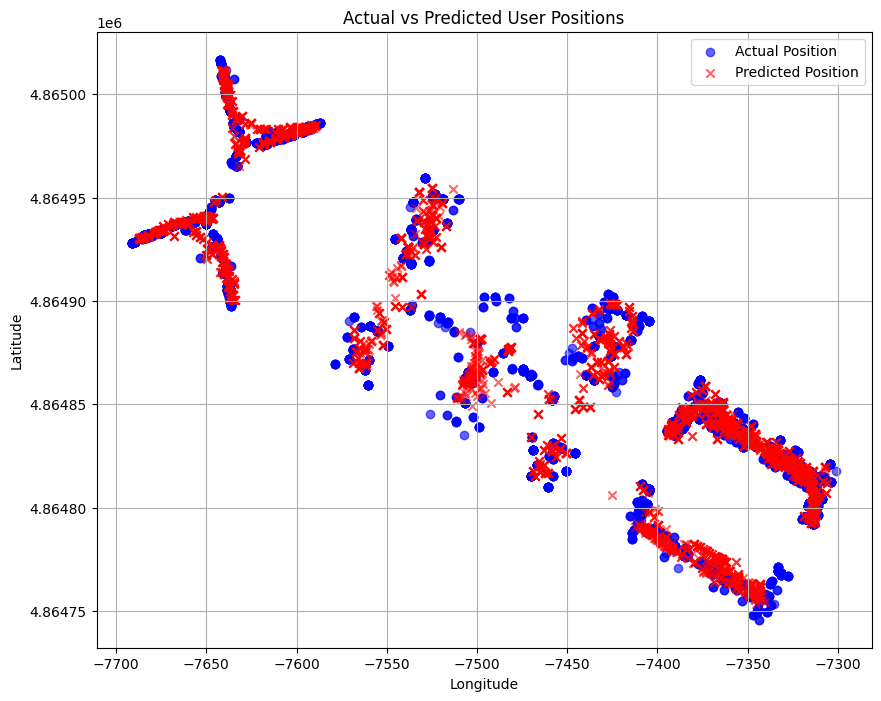

In [11]:
# Scatter plot for actual vs predicted user positions
plt.figure(figsize=(10, 8))
plt.scatter(y_test_actual[:, 0], y_test_actual[:, 1], color='blue', label='Actual Position', alpha=0.6)
plt.scatter(y_pred_actual[:, 0], y_pred_actual[:, 1], color='red', marker='x', label='Predicted Position', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted User Positions')
plt.legend()
plt.grid(True)
plt.show()